In [47]:
%load_ext autoreload
%autoreload 2

from cuadripolos import Cuadripolo 
import numpy as np
from sympy import * 
import pandas as pd 
import matplotlib.pyplot as plt
#para scalar y comparar piolita
from sklearn import preprocessing
from scipy.signal import argrelextrema
min_max_scaler = preprocessing.MinMaxScaler()
plt.rcParams["axes.labelsize"] = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams["axes.titlesize"] = 20
plt.rcParams["xtick.labelsize"] = 17
plt.rcParams["ytick.labelsize"] = 17

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Tl por método finito 

In [48]:
freq = pd.read_csv('Grafico TL texto.csv', sep = ' ', header = None)
freq = freq.dropna(axis=1, how='all')
freq[22].fillna(freq[23], inplace = True)
freq[22].fillna(freq[24], inplace = True)
freq.drop(columns = [23, 24], inplace = True)
tl_comsol = freq.rename(columns = {22: 'tl', 0:'frequency'})
tl_comsol

,frequency,tl
0,50,0.801251
1,55,2.889522
2,60,4.446196
3,65,5.585793
4,70,6.358499
...,...,...
986,4980,13.968265
987,4985,15.380851
988,4990,2.143976
989,4995,10.831078


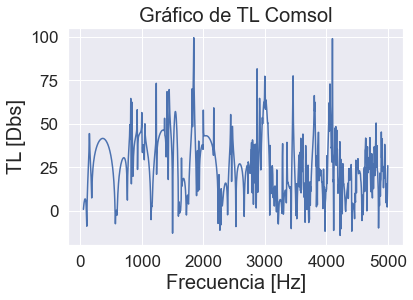

In [49]:
fig, ax = plt.subplots()
ax.plot(tl_comsol['frequency'], tl_comsol['tl'])
ax.set(xlabel='Frecuencia [Hz]', ylabel='TL [Dbs]',
       title='Gráfico de TL Comsol')
plt.show()

# Metodo Analítico por cuadripolos

## silenciador 1. 
silenciador:
- 1 Cámara de expansión
- 2 tubo
- 3 Cámara de expansión 
- 4 Resonador de helmholtz

In [50]:
# 1 cámara
camara_s = np.pi*0.125*0.06
camara_s1 = camara_s2 = np.pi*(0.02**2)
camara_largo = 0.3
# 2 tubo 
tubo_s = tubo_s1 = np.pi*(0.02**2)
tubo_largo = 0.19 
# 3 camara 
camara_s = np.pi*0.125*0.06
camara_s1 = camara_s2 = np.pi*(0.02**2)
# 4 resonador
helmholtz_s1 = (0.02**2)*np.pi
helmholtz_s = camara_s
helmholtz_l= 0.01
helmholtz_v = (helmholtz_s*0.19) - (tubo_largo*tubo_s) 
helmholtz_ss = 0.15*0.06*np.pi

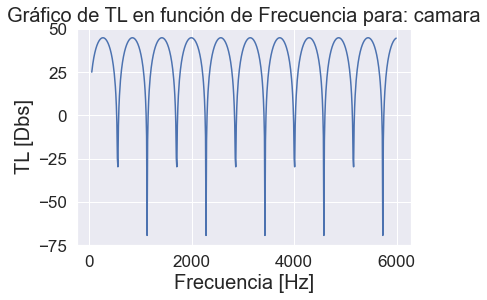

In [51]:
#camara
camara = Cuadripolo(s=camara_s, largo=camara_largo, s1=camara_s1, s2=camara_s2, tipo = 'camara')
camara.coeficientes()
camara.obtencion_tl()
camara.plot_tl()

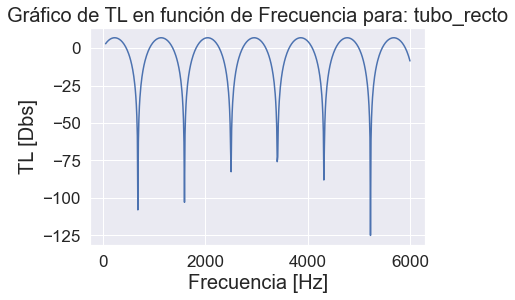

In [52]:
#tubo 
tubo = Cuadripolo(tubo_s, largo = tubo_largo, tipo = 'tubo_recto')
tubo.coeficientes()
tubo.obtencion_tl()
tubo.plot_tl()

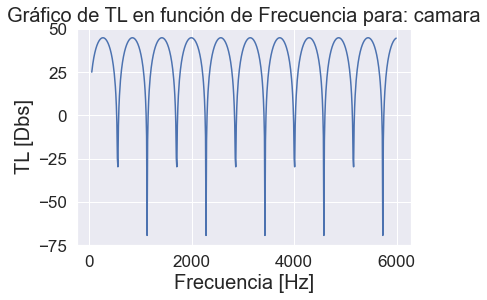

In [53]:
#camara 
camara_3 = Cuadripolo(s = camara_s, s1 = camara_s1, s2 = camara_s2, largo = camara_largo, tipo = 'camara')
camara_3.coeficientes()
camara_3.obtencion_tl()
camara_3.plot_tl()

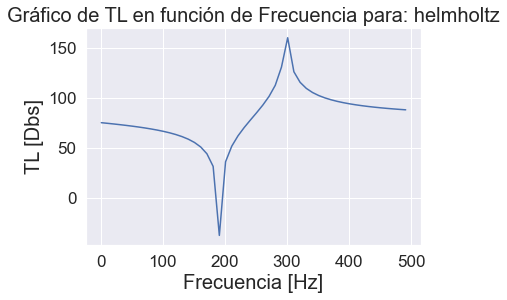

In [54]:
reso = Cuadripolo(s = helmholtz_s, largo = helmholtz_l, s1 = helmholtz_s1, tipo = 'helmholtz', vol = helmholtz_v)
reso.coeficientes()
reso.obtencion_tl()
reso.plot_tl(values = np.arange(1, 500, 10))

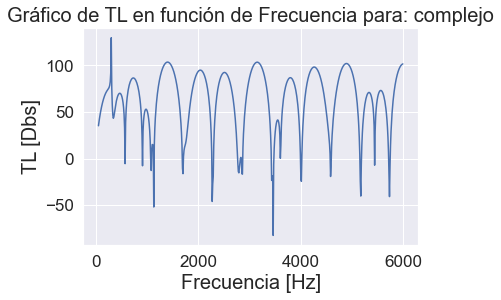

In [55]:
# total
silenciador_total = camara * tubo * camara_3 * reso
silenciador_total.s1 = silenciador_total.s2 = np.pi * 0.02 ** 2
silenciador_total.obtencion_tl()
silenciador_total.plot_tl()

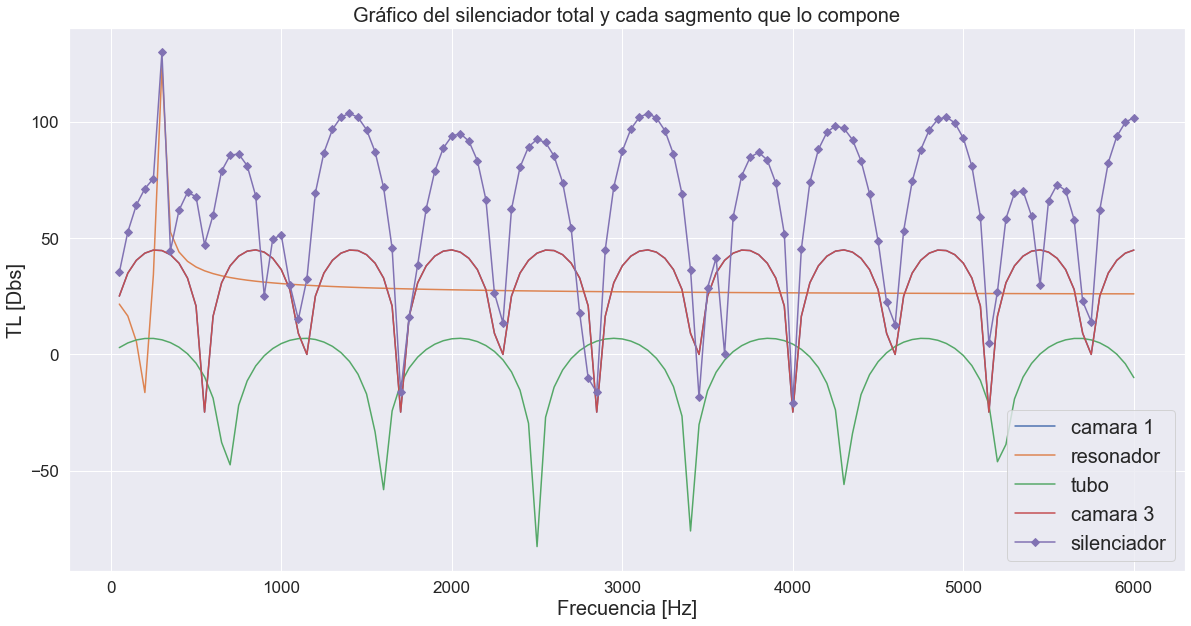

In [56]:
x = np.arange(50,6050,50)
fig, ax = plt.subplots(figsize = (20,10))
ax.plot(x, camara.tl_(x), label = 'camara 1')
ax.plot(x, reso.tl_(x)-50, label = 'resonador')
ax.plot(x, tubo.tl_(x), label = 'tubo')
ax.plot(x, camara_3.tl_(x), label = 'camara 3')
ax.plot(x, silenciador_total.tl_(x), label = 'silenciador', marker = 'D')
ax.set(xlabel='Frecuencia [Hz]', ylabel='TL [Dbs]',
       title='Gráfico del silenciador total y cada sagmento que lo compone')
ax.legend(loc = 'best')
plt.show()
#fig.savefig('cuadripolos_plots/suma_silenciadores.png')

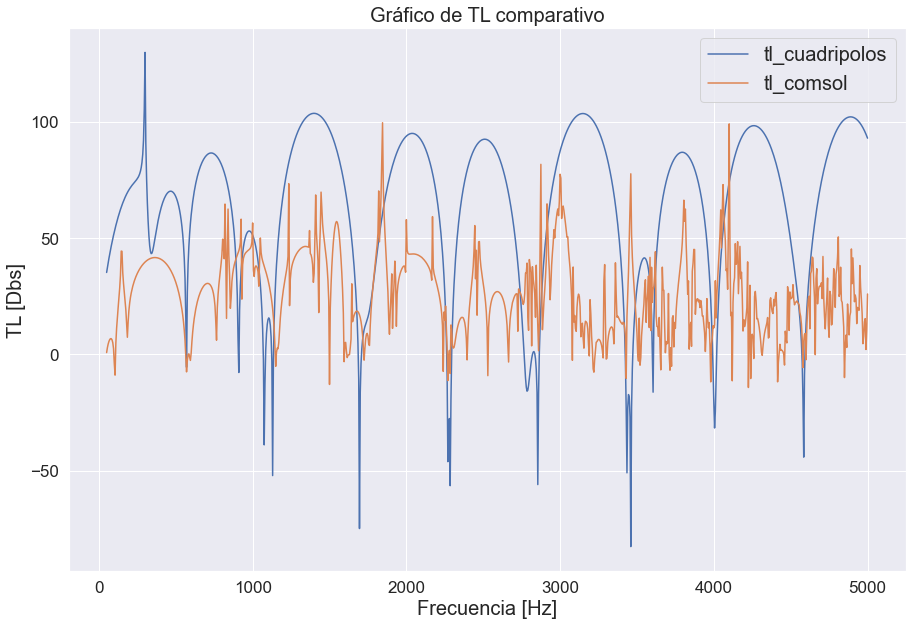

[[1.         0.14429022]
 [0.14429022 1.        ]]


In [61]:
x = np.arange(50,5005,5)
y_silenciador = silenciador_total.tl_(x) 
y_comsol = tl_comsol['tl']
xcoords = tl_comsol.loc[argrelextrema(y_silenciador, np.greater)[0]]['frequency'].values
fig, ax = plt.subplots(figsize = (15,10))
ax.plot(x, y_silenciador, label = 'tl_cuadripolos')
ax.plot(tl_comsol['frequency'], y_comsol, label = 'tl_comsol')
ax.set(xlabel='Frecuencia [Hz]', ylabel='TL [Dbs]',
       title='Gráfico de TL comparativo')
ax.legend(loc = 'best')
#ax.set_xticks(list(xcoords[0:9]))
#for xc in xcoords[0:9]:
#    plt.axvline(x=xc, color='k', linestyle='dotted')
plt.show()
print(np.corrcoef(y_silenciador, y_comsol))

fig.savefig('cuadripolos_plots/grafico_tl_comparativo.png')

### Análisis de maximos locales 

In [58]:
x[argrelextrema(y_silenciador, np.greater)[0]]

array([ 300,  465,  730,  980, 1105, 1400, 2040, 2280, 2510, 2830, 3150,
       3445, 3550, 3795, 4260, 4890])

In [59]:
tl_comsol.loc[argrelextrema(tl_comsol['tl'].values, np.greater)]['frequency'].values


array([  80,  145,  365,  585,  705,  805,  820,  840,  925, 1000, 1020,
       1050, 1160, 1235, 1345, 1370, 1410, 1445, 1545, 1605, 1645, 1680,
       1745, 1820, 1845, 1905, 1925, 1985, 2000, 2045, 2170, 2245, 2255,
       2280, 2290, 2360, 2445, 2455, 2475, 2590, 2715, 2730, 2775, 2785,
       2800, 2820, 2845, 2875, 2915, 2960, 2985, 3000, 3020, 3050, 3085,
       3095, 3120, 3145, 3165, 3195, 3250, 3290, 3335, 3360, 3375, 3410,
       3460, 3515, 3555, 3575, 3585, 3595, 3620, 3645, 3665, 3690, 3705,
       3720, 3735, 3745, 3805, 3815, 3835, 3850, 3870, 3895, 3905, 3915,
       3930, 3955, 3970, 3995, 4010, 4045, 4060, 4085, 4100, 4115, 4140,
       4155, 4170, 4180, 4195, 4220, 4235, 4250, 4270, 4285, 4350, 4370,
       4390, 4405, 4430, 4440, 4465, 4480, 4495, 4515, 4540, 4595, 4620,
       4640, 4670, 4690, 4700, 4710, 4740, 4755, 4780, 4810, 4825, 4860,
       4870, 4895, 4905, 4920, 4935, 4950, 4985])

## silenciador 2

- 1 Cámara de expansión
- 2 tubo
- 3 Cámara de expansión 
- 4 
 - 4.1 Extensión expansión
 - 4.2 Tubo cerrado

In [68]:
#tubo cerrado
tubo_cerrado_l = 0.19
tubo_cerrado_s = np.pi*0.125*0.6
tubo_cerrado_s1 = np.pi*(0.02**2)

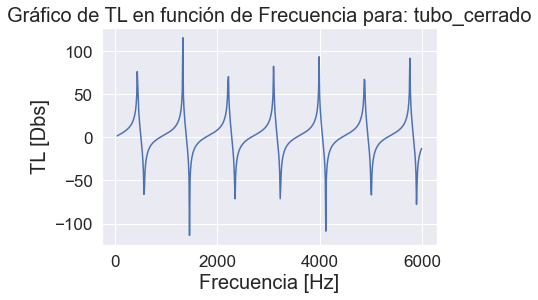

In [69]:
tubo_cerrado = Cuadripolo(tubo_cerrado_s, tubo_cerrado_l, s1 = tubo_cerrado_s1, tipo = 'tubo_cerrado')
tubo_cerrado.coeficientes()
tubo_cerrado.obtencion_tl()
tubo_cerrado.plot_tl()

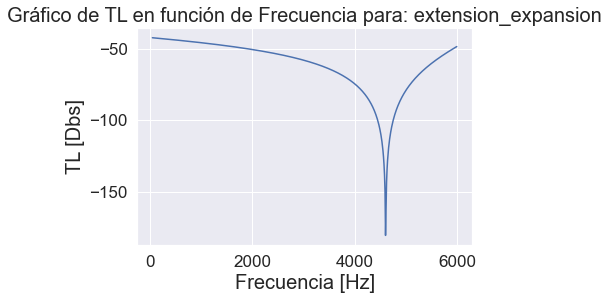

In [70]:
    #4.1 extensión_expansión
exten_expan_s1 = np.pi*(0.02**2)
exten_expan_s = np.pi*0.126*0.06
exten_expan_l = 0.01
extension = Cuadripolo(exten_expan_s, exten_expan_l, exten_expan_s1, tipo = 'extension_expansion')
extension.coeficientes()
extension.obtencion_tl()
extension.plot_tl()

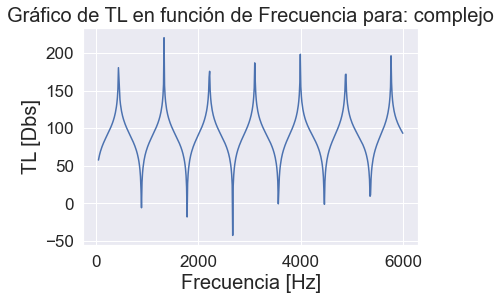

In [71]:
#tubo cerrado x extension 
tubo_extension = extension * tubo_cerrado 
tubo_extension.s2 = tubo_extension.s1 = np.pi * 0.02 ** 2 
tubo_extension.cuadri
tubo_extension.obtencion_tl()
tubo_extension.plot_tl()

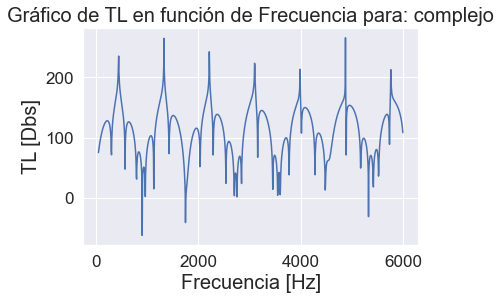

In [72]:
# total 
silenciador_total_2 = camara * tubo * camara_3 * tubo_extension
silenciador_total_2.s1 = np.pi * (0.02 ** 2)
silenciador_total_2.s2 = np.pi * (0.02 ** 2)
silenciador_total_2.obtencion_tl()
silenciador_total_2.plot_tl(values = np.arange(50, 6000, 5))

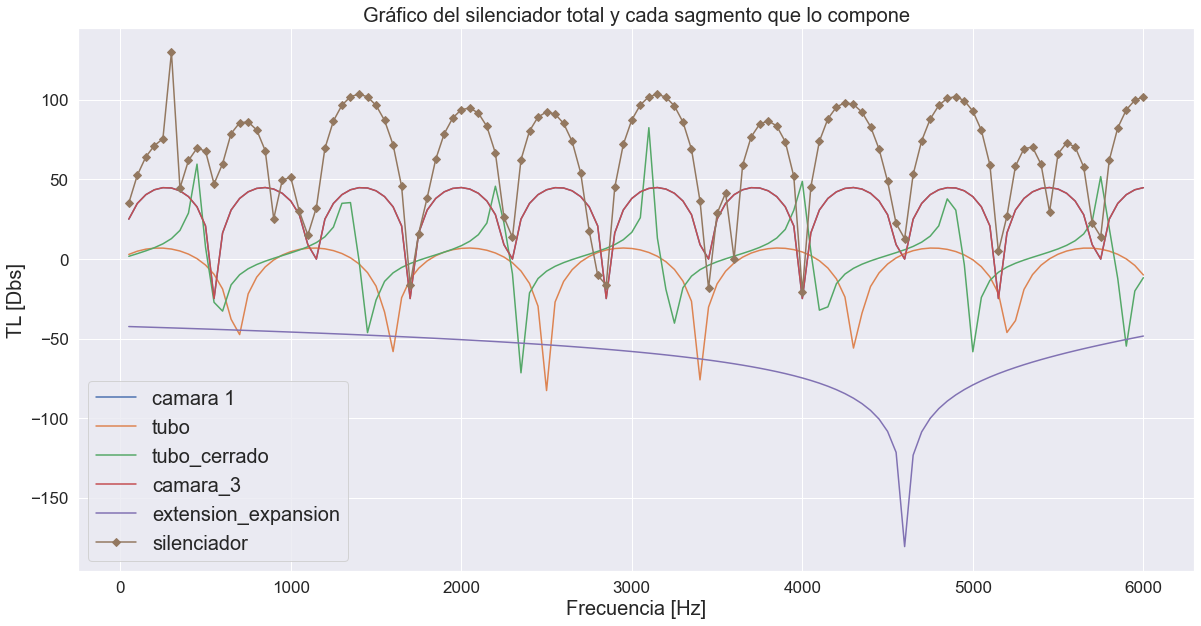

In [73]:
x = np.arange(50,6050,50)
fig, ax = plt.subplots(figsize = (20,10))
ax.plot(x, camara.tl_(x), label = 'camara 1')
ax.plot(x, tubo.tl_(x), label = 'tubo')
ax.plot(x, tubo_cerrado.tl_(x), label = 'tubo_cerrado')
ax.plot(x, camara_3.tl_(x), label = 'camara_3')
ax.plot(x, extension.tl_(x), label = 'extension_expansion')
ax.plot(x, silenciador_total.tl_(x), label = 'silenciador', marker = 'D')
ax.set(xlabel='Frecuencia [Hz]', ylabel='TL [Dbs]',
       title='Gráfico del silenciador total y cada sagmento que lo compone')
ax.legend(loc = 'best')
plt.show()
#fig.savefig('cuadripolos_plots/suma_silenciadores_extension_tubo.png')

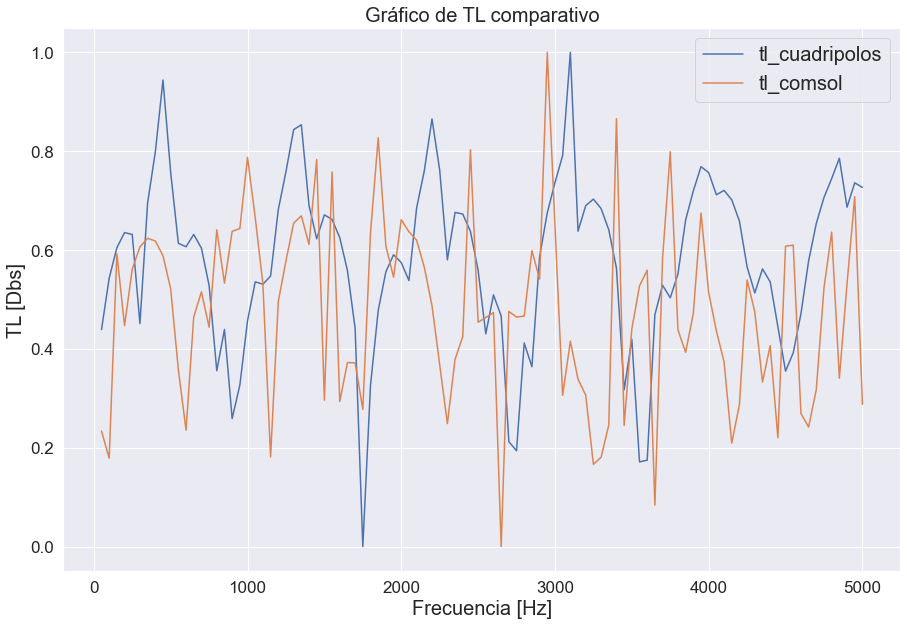

[[1.         0.03221271]
 [0.03221271 1.        ]]


In [74]:
x = np.arange(50,5050,50)
y_silenciador = min_max_scaler.fit_transform(silenciador_total_2.tl_(x).reshape(-1, 1))
y_comsol = min_max_scaler.fit_transform(tl_comsol['tl'].values.reshape(-1, 1))
fig, ax = plt.subplots(figsize = (15,10))
ax.plot(x, y_silenciador, label = 'tl_cuadripolos')
ax.plot(tl_comsol['frequency'], y_comsol, label = 'tl_comsol')
ax.set(xlabel='Frecuencia [Hz]', ylabel='TL [Dbs]',
       title='Gráfico de TL comparativo')
ax.legend(loc = 'best')
plt.show()
print(np.corrcoef(y_silenciador.reshape(1, -1), y_comsol.reshape(1, -1)))
#fig.savefig('cuadripolos_plots/grafico_tl_comparativo_extension_cerrado.png')

## silenciador 3:
- 1 Cámara de expansión
- 2 tubo
- 3 Cámara de expansión 
- 4 
 - 4.1 tubo cerrado
 - 4.2 tubo cerrado

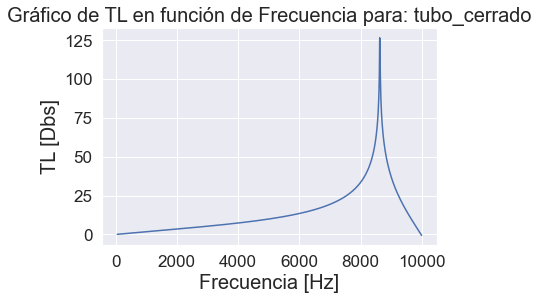

In [75]:
tubo_cerrado_remplazo = Cuadripolo(s=np.pi*(0.02**2), largo=0.01, tipo ='tubo_cerrado')
tubo_cerrado_remplazo.coeficientes()
tubo_cerrado_remplazo.obtencion_tl()
tubo_cerrado_remplazo.plot_tl(values = np.arange(50,10000,10))

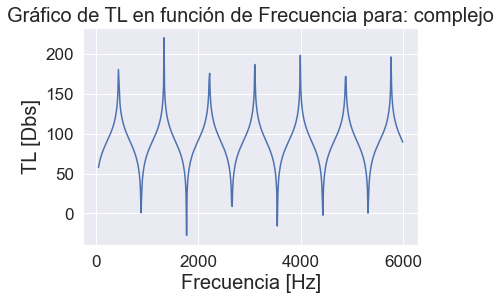

In [76]:
#tubo cerrado x tubo cerrado 
tubo_tubo = tubo_cerrado_remplazo * tubo_cerrado 
tubo_tubo.s2 = tubo_tubo.s1 = np.pi * 0.02 ** 2 
tubo_tubo.cuadri
tubo_tubo.obtencion_tl()
tubo_tubo.plot_tl()

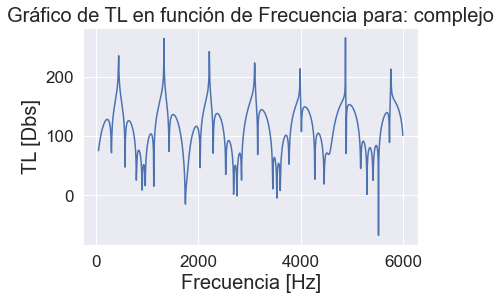

In [77]:
# total 
silenciador_total_3 = camara * tubo * camara_3 * tubo_tubo
silenciador_total_3.s1 = np.pi * (0.02 ** 2)
silenciador_total_3.s2 = np.pi * (0.02 ** 2)
silenciador_total_3.obtencion_tl()
silenciador_total_3.plot_tl(values = np.arange(50, 6000, 5))

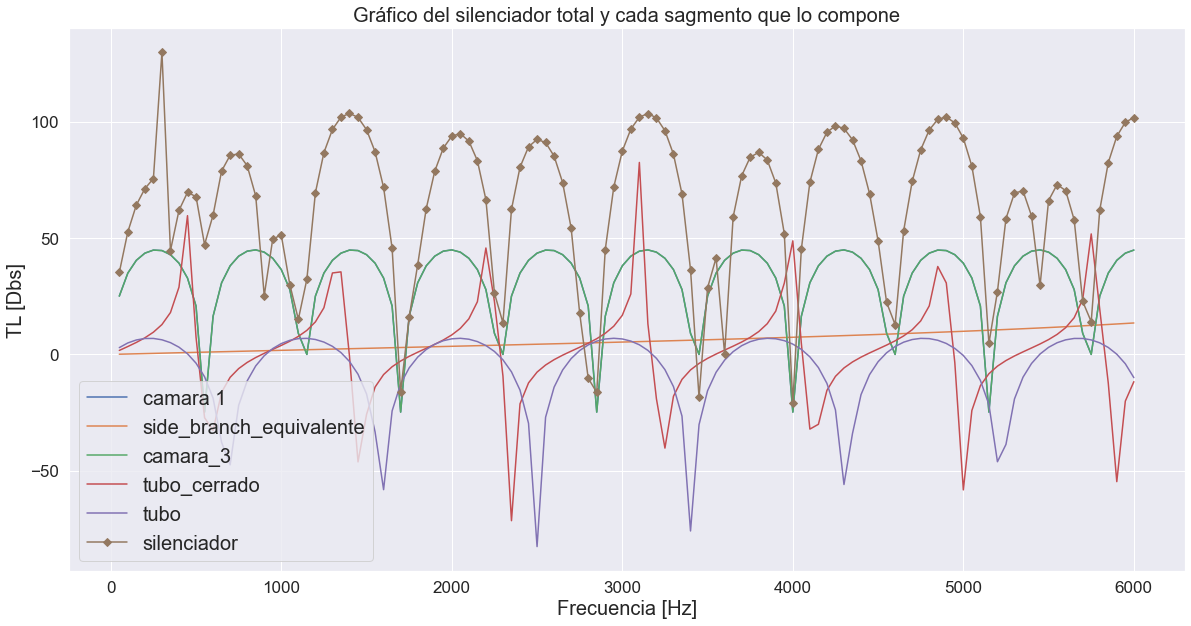

In [78]:
x = np.arange(50,6050,50)
fig, ax = plt.subplots(figsize = (20,10))
ax.plot(x, camara.tl_(x), label = 'camara 1')
ax.plot(x, tubo_cerrado_remplazo.tl_(x), label = 'side_branch_equivalente')
ax.plot(x, camara_3.tl_(x), label = 'camara_3')
ax.plot(x, tubo_cerrado.tl_(x), label = 'tubo_cerrado')
ax.plot(x, tubo.tl_(x), label = 'tubo')
ax.plot(x, silenciador_total.tl_(x), label = 'silenciador', marker = 'D')
ax.set(xlabel='Frecuencia [Hz]', ylabel='TL [Dbs]',
       title='Gráfico del silenciador total y cada sagmento que lo compone')
ax.legend(loc = 'best')
plt.show()
#fig.savefig('cuadripolos_plots/suma_silenciadores_tubo_tubo.png')

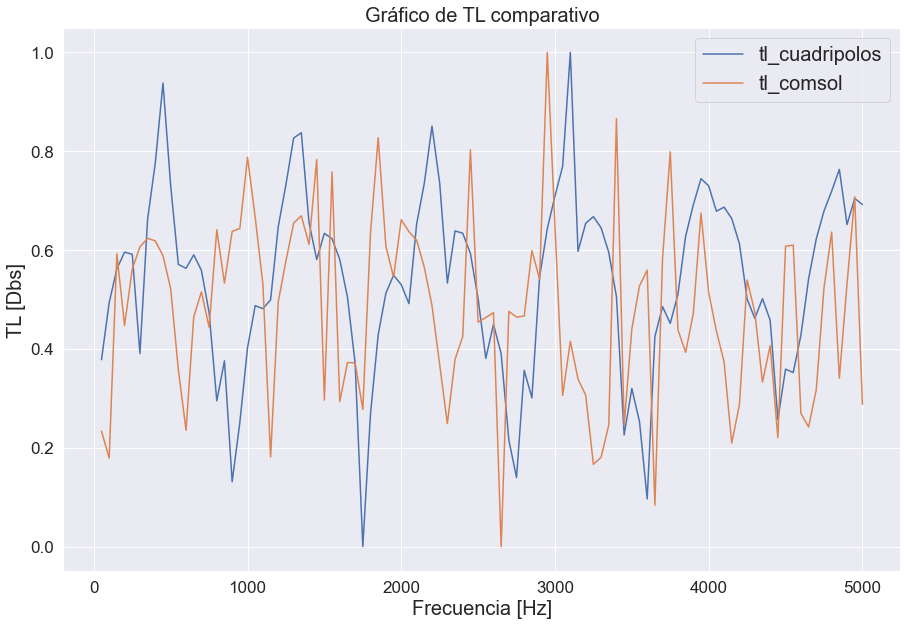

[[1.        0.0482961]
 [0.0482961 1.       ]]


In [79]:
x = np.arange(50,5050,50)
y_silenciador = min_max_scaler.fit_transform(silenciador_total_3.tl_(x).reshape(-1, 1))
y_comsol = min_max_scaler.fit_transform(tl_comsol['tl'].values.reshape(-1, 1))
fig, ax = plt.subplots(figsize = (15,10))
ax.plot(x, y_silenciador, label = 'tl_cuadripolos')
ax.plot(tl_comsol['frequency'], y_comsol, label = 'tl_comsol')
ax.set(xlabel='Frecuencia [Hz]', ylabel='TL [Dbs]',
       title='Gráfico de TL comparativo')
ax.legend(loc = 'best')
plt.show()
print(np.corrcoef(y_silenciador.reshape(1, -1), y_comsol.reshape(1, -1)))
#fig.savefig('cuadripolos_plots/grafico_tl_comparativo_cerrado_cerrado.png')